# Inter-model comparison of SST anomalies
# PDFs of different EERIE models for DV8

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
from IPython.display import display, HTML
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_PDFs import *
#DV8_functions(1) packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

/home/b/b382616/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39955 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/39955/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/39955/status,Workers: 32
Total threads: 32,Total memory: 486.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45039,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/39955/status,Total threads: 32
Started: Just now,Total memory: 486.93 GiB
Comm: tcp://127.0.0.1:43517,Total threads: 1
Dashboard: /user/b382616/levante-spawner-preset//proxy/39471/status,Memory: 15.22 GiB
Nanny: tcp://127.0.0.1:33641,


# LOAD DATA
#### the functions need datasets of SST anomalies with dimensions (time,lat,lon)
#### Only take latitudes between 50°S and 70°N, to retain only ice-free oceans. To make sure no sea ice appears in these latitudes we apply SSTA=SSTA.where(sst>-1.7) for all anomalies.
#### Gridcells with sea ice are defined in OSTIA,ICON and IFS-FESOM as an SST value of ~ -1.75, by applying the 'where' condition we make sure to only take ice free times and grid-cells without throwing out entire areas, but only the times and places where sea ice appears.
#### Also, convert ICON and IFS-FESOM longitudes from 0->360 to -180->180 and interpolate them to OSTIA's grid

In [3]:

def lon_180w_180e(ds_sice: xr.DataArray):
    ds_sice = (
        ds_sice
        .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)
        .sortby('lon'))

    return ds_sice

In [4]:
#SST

# OSTIA
filename='/scratch/b/b382615/mhws/ostia.zarr' 
sst = xr.open_zarr(str(filename), chunks={'time':150, 'lat':-1, 'lon':-1}).sst
sst=sst.sel(lat=slice(-50, 70))
sst=sst-273.15

# ICON HISTORICAL
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_ic = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':150, 'lat':-1, 'lon':-1})
sst_ic=sst_ic.sel(lat=slice(-50, 70))


# IFS FESOM
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.ifs-fesom2-sr.hist-1950.v20240304.ocean.gr025']#.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_f = dat['2D_daily_avg_1950-2014'].to_dask().avg_tos.isel(depth=0).drop_vars('depth').chunk({'time':150, 'lat':-1, 'lon':-1})
sst_f=sst_f.sel(lat=slice(-50, 70))
            


In [5]:
# OSTIA ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ds = ds.sel(lat=slice(-50, 70))
ossta=ds['dat_anomaly']
sst=sst.sel(time=slice((ossta.time[0].values),str(ossta.time[-1].values))) #making sure SST time matches SSTA time before masking the sea ice

ossta=ossta.where(sst>-1.7) #remove from anomalies places and times where there is sea ice

# OSTIA BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_track_1982_2014_maxanom5_mask70_oct25.zarr'
oblobs = xr.open_zarr(str(file_name), chunks={})


In [6]:
# OSTIA DETREND FIXED BASELINE
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_FixedDetrend_hob_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_fix = xr.open_zarr(str(file_name), chunks=chunks)
ds_fix = ds_fix.sel(lat=slice(-50, 70))
ossta_fix=ds_fix['dat_anomaly']



In [7]:
# ICON HIST ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
i_ds = xr.open_zarr(str(file_name), chunks=chunks)
i_ds=lon_180w_180e(i_ds)
sst_ic=lon_180w_180e(sst_ic)
i_ds = i_ds.sel(lat=slice(-50, 70))
issta=i_ds['dat_anomaly']
sst_ic=sst_ic.sel(time=slice(str(issta.time[0].values),str(issta.time[-1].values)))
# Interpolate the sea ice mask to match your data grid
sst_ic_aligned = sst_ic.interp(lat=issta.lat, lon=issta.lon, method='nearest')
# Now apply the sea ice mask
issta = issta.where(sst_ic_aligned > -1.7)
issta = issta.interp(lat=ossta.lat, lon=ossta.lon)



# ICON HIST BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_track_1982_2014_maxanom5_mask70_oct25.zarr'
iblobs = xr.open_zarr(str(file_name), chunks={})
iblobs=lon_180w_180e(iblobs)

In [8]:
# IFS-FESOM ANOMALIES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOMhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
f_ds = xr.open_zarr(str(file_name), chunks=chunks)
f_ds=lon_180w_180e(f_ds)
sst_f=lon_180w_180e(sst_f)
f_ds = f_ds.sel(lat=slice(-50, 70))
fssta=f_ds['dat_anomaly']
sst_f=sst_f.sel(time=slice((fssta.time[0].values),str(fssta.time[-1].values)))
# Interpolate the sea ice mask to match your data grid
sst_f_aligned = sst_f.interp(lat=fssta.lat, lon=fssta.lon, method='nearest')
# Now apply the sea ice mask
fssta = fssta.where(sst_f_aligned > -1.7)
fssta = fssta.interp(lat=ossta.lat, lon=ossta.lon)




# IFS-FESOM BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOM_track_1982_2014_maxanom5_mask70_oct25.zarr'
fblobs = xr.open_zarr(str(file_name), chunks={})
fblobs=lon_180w_180e(fblobs)

# Examples

# Regional masks
### region_masks.zarr is already in this folder and in the shapefile path, but you can create the mask following these steps:

Create regional masks based on SST variance relevance.

You have to download the oceanic regions from the shapefile at

Flanders Marine Institute (2021). Global Oceans and Seas, version 1. Available online at https://www.marineregions.org/. https://doi.org/10.14284/542.


Put this file in the same place as your shapefile_path. This file is then heavily modified to  adapt it to the wanted regions.

The 'create_oceanic_regions_mask' function needs a one-time slice of global sst to work.

You have to provide an example_sst for the oceanic regions masks to be created: Any single time slice of lat and lon will work.

if you don't specify it in the funbction call here,i.e.:

masks = create_oceanic_regions_mask(lats, lons,example_sst=something, method='shapefile')

then it's going to look for it in the same path where I saved my shapefile.

This is what I did:

In [9]:


##Save it to wherever the function create_shapefile_oceanic_regions_mask points to

##for OSTIA
#file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
#chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
#ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


#ds_exmp['dat_anomaly'].isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ostia.nc')

##for ICON
#issta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_icon.nc')

##for IFS FESOM

#fssta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ifsfesom.nc')

Creating masks from shapefile...


ERROR 1: PROJ: internal_proj_create_from_database: /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


Applying region modifications...
Removed Baltic_Sea from regions
Removed South_China_Eastern_Archipelagic_Seas from regions
Ensuring masks are mutually exclusive...
Verifying no overlaps between masks...
  ✅ SUCCESS: No overlaps found between any masks
Masks saved to /scratch/b/b382616/mhws/DV8/region_masks.zarr
Loading existing masks...


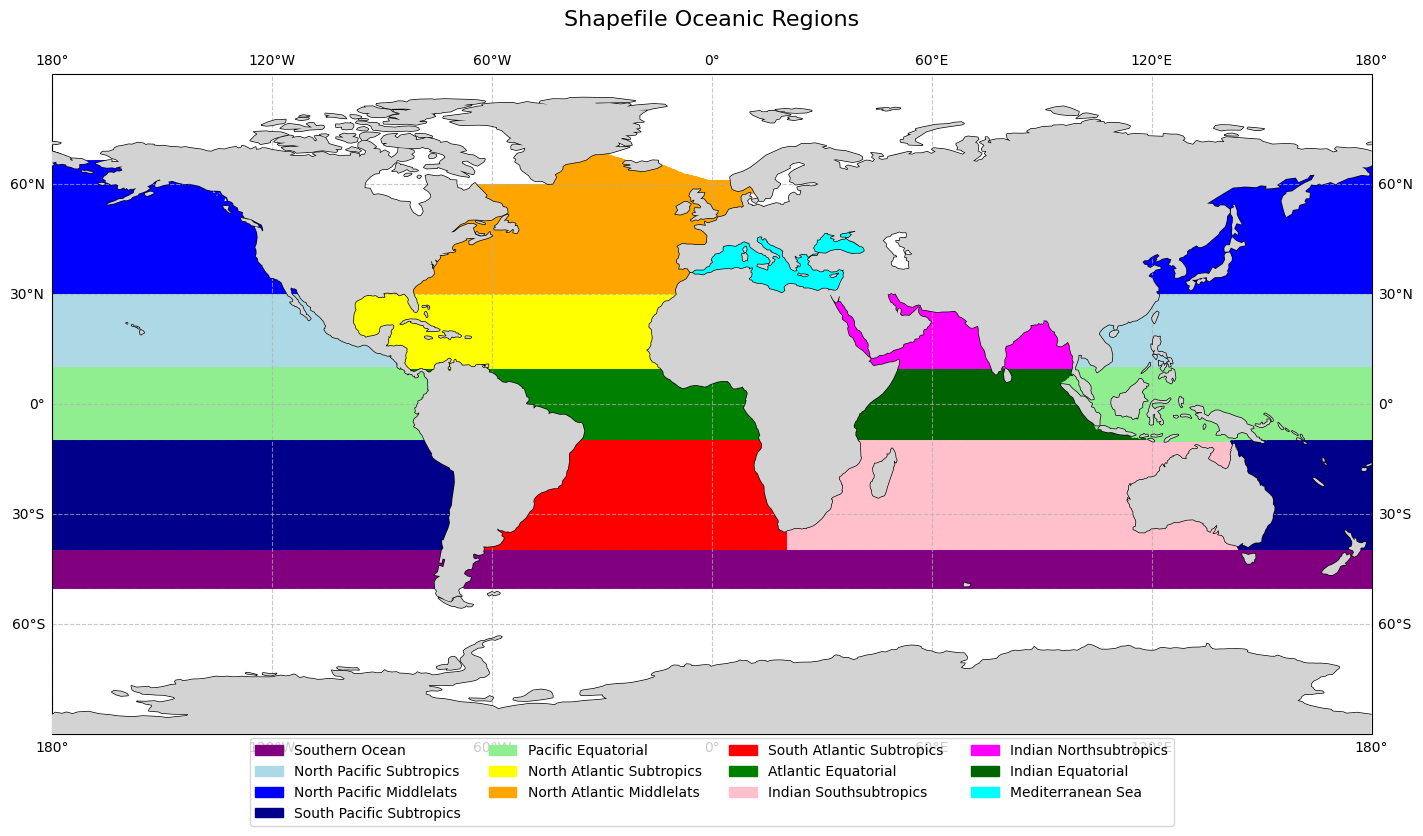

In [7]:

# LATS and LONS for mask
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


lats=ds_exmp.lat
lons=ds_exmp.lon

# Old method (coordinate-based)
#masks_old = create_oceanic_regions_mask(lats, lons, method='coordinate')

# Create shapefile masks (no example_sst needed!)
masks = create_oceanic_regions_mask(lats, lons, method='shapefile')

# Or plot directly
fig, ax = plot_shapefile_regions(lats, lons)

# GLOBAL PDFs of SST anomaly

to select from dataset:
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}

ds= dataset 

dat_anomaly=variable to be selected


In [22]:
# to select SSTA durectly:
models_dict = {
    'OSTIA': ossta,  # direct data array
    'ICON': issta,   # direct data array  
    'IFS-FESOM': fssta,  # direct data array
}

COMPUTING GLOBAL PDFS 
Processing OSTIA...
  Total points: 3,109,518,319
  Mean: 0.115, Std: 0.826
Processing ICON...
  Total points: 1,296,727,615
  Mean: 0.164, Std: 0.840
Processing IFS-FESOM...
  Total points: 1,293,043,276
  Mean: 0.216, Std: 0.923


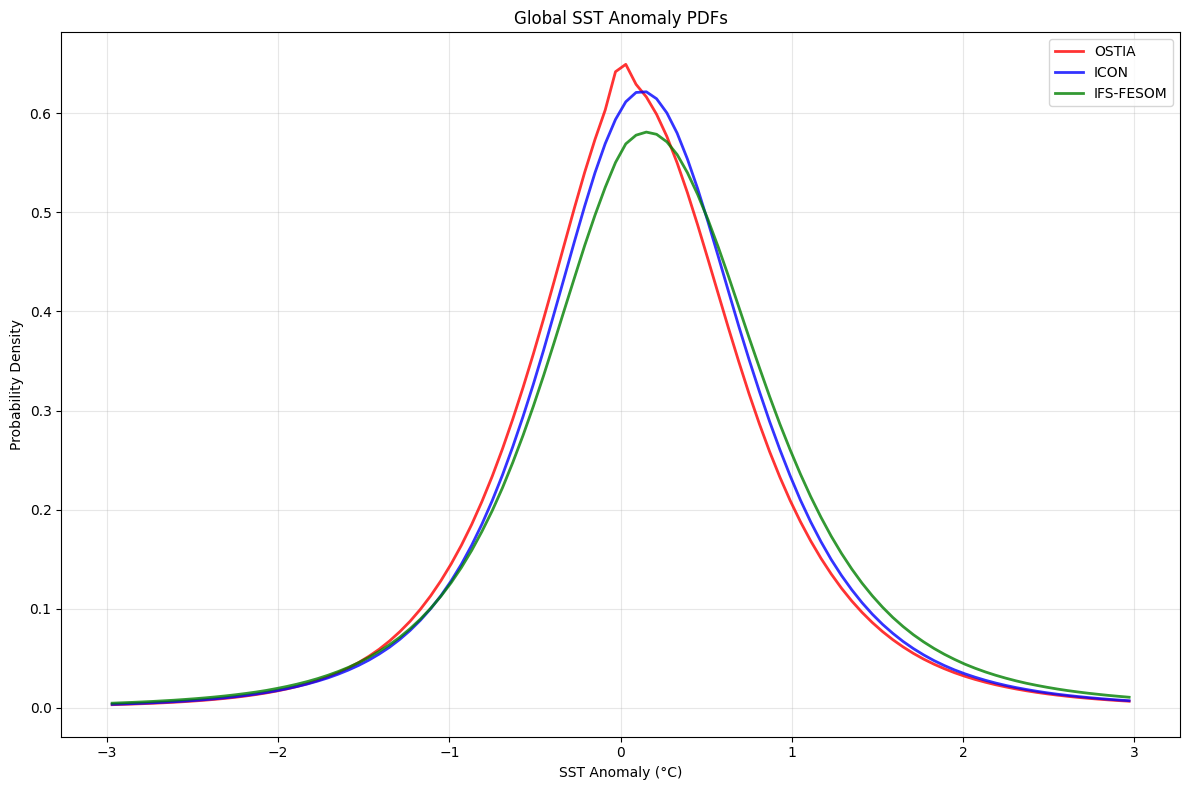


GLOBAL STATISTICS:
Model           |     Mean |      Std |  Data Points
------------------------------------------------------------
OSTIA           |    0.115 |    0.826 | 3,109,518,319
ICON            |    0.164 |    0.840 | 1,296,727,615
IFS-FESOM       |    0.216 |    0.923 | 1,293,043,276


In [23]:
# Global analysis

global_pdfs = quick_global_analysis(models_dict,xlim=(-3,3))


# REGIONAL PDFs of SST anomaly

#### Available regions:
                Southern_Ocean
                North_Pacific_SubTropics
                North_Pacific_MiddleLats
                South_Pacific_SubTropics
                Pacific_Equatorial
                North_Atlantic_SubTropics
                North_Atlantic_MiddleLats
                South_Atlantic_SubTropics
                Atlantic_Equatorial
                Indian_SouthSubTropics
                Indian_NorthSubTropics
                Indian_Equatorial
                Mediterranean_Sea

In [9]:
# to select SSTA durectly:
models_dict = {
    'OSTIA': ossta,  # direct data array
    'ICON': issta,   # direct data array  
    'IFS-FESOM': fssta,  # direct data array
}

COMPUTING REGIONAL PDFS (ULTRA-FAST)
Creating model-specific masks...
Creating model-specific masks...
Creating masks for OSTIA...
Loading existing masks...
  OSTIA grid: (480,) x (1440,)
Creating masks for ICON...
Loading existing masks...
  ICON grid: (480,) x (1440,)
Creating masks for IFS-FESOM...
Loading existing masks...
  IFS-FESOM grid: (480,) x (1440,)

Processing model: OSTIA
  Region: Atlantic_Equatorial
    110,248,929 points, mean: 0.125
  Region: Indian_Equatorial
    120,174,159 points, mean: 0.119
  Region: Indian_NorthSubTropics
    54,240,396 points, mean: 0.132
  Region: Indian_SouthSubTropics
    289,994,187 points, mean: 0.150
  Region: Mediterranean_Sea
    32,193,167 points, mean: 0.343
  Region: North_Atlantic_MiddleLats
    223,727,219 points, mean: 0.248
  Region: North_Atlantic_SubTropics
    155,319,990 points, mean: 0.187
  Region: North_Pacific_MiddleLats
    315,246,859 points, mean: 0.162
  Region: North_Pacific_SubTropics
    305,315,850 points, mean: 0

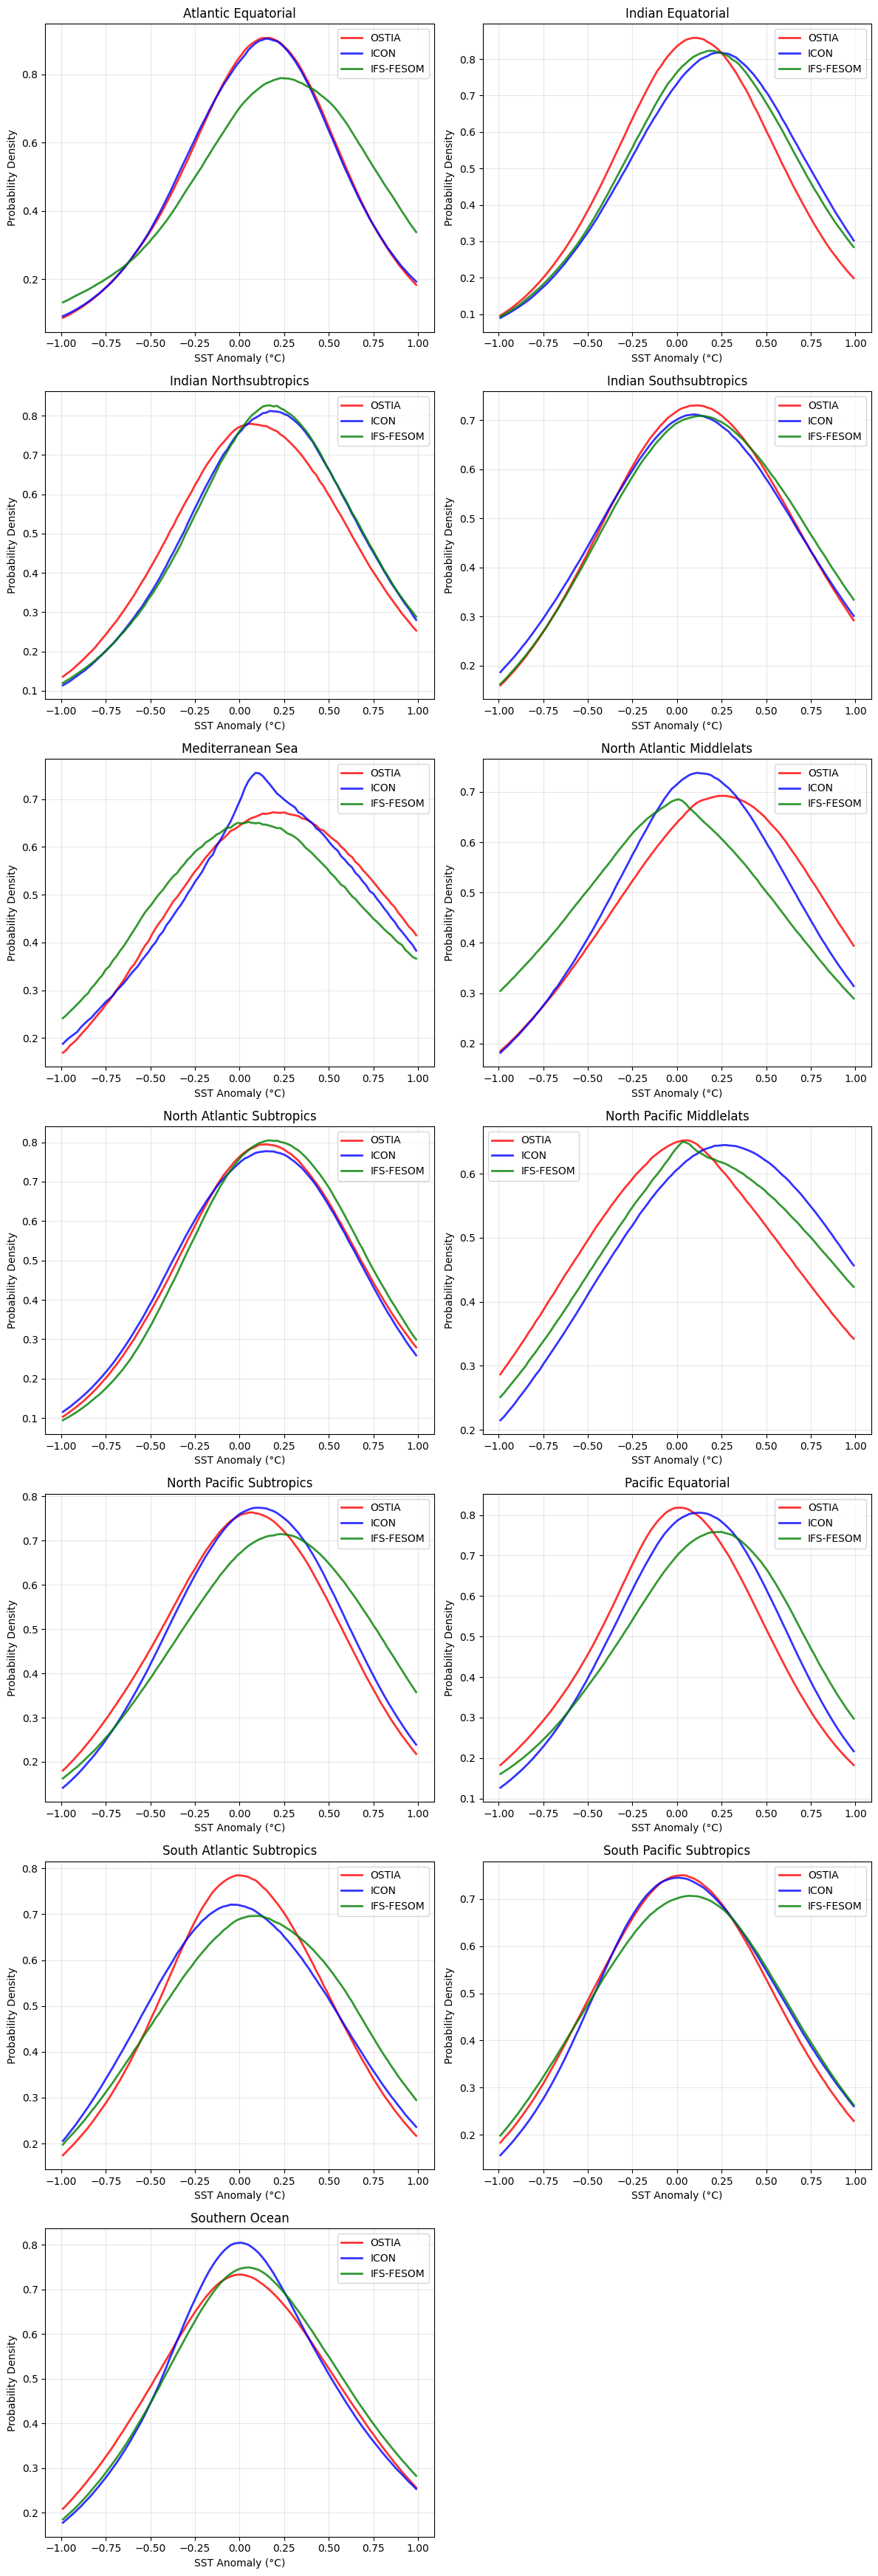


REGIONAL STATISTICS:

Atlantic Equatorial:
Model           |     Mean |      Std |  Data Points
------------------------------------------------------------
OSTIA           |    0.125 |    0.559 |  110,248,929
ICON            |    0.129 |    0.604 |  110,058,312
IFS-FESOM       |    0.166 |    0.874 |  109,752,930

Indian Equatorial:
Model           |     Mean |      Std |  Data Points
------------------------------------------------------------
OSTIA           |    0.119 |    0.585 |  120,174,159
ICON            |    0.219 |    0.625 |  120,108,429
IFS-FESOM       |    0.205 |    0.679 |  120,080,684

Indian Northsubtropics:
Model           |     Mean |      Std |  Data Points
------------------------------------------------------------
OSTIA           |    0.132 |    0.694 |   54,240,396
ICON            |    0.179 |    0.683 |   54,049,779
IFS-FESOM       |    0.197 |    0.801 |   53,788,468

Indian Southsubtropics:
Model           |     Mean |      Std |  Data Points
--------------

In [10]:
regional_pdfs, masks = quick_regional_analysis(models_dict, xlim=(-1, 1), method='ultrafast')

In [ ]:
regional_pdfs, masks = compute_regional_pdfs_classic_ultrafast(models_dict, xlim=(-1, 1))

# Seasonal PDF

#### Available regions:
                Southern_Ocean
                North_Pacific_SubTropics
                North_Pacific_MiddleLats
                South_Pacific_SubTropics
                North_Atlantic_SubTropics
                North_Atlantic_MiddleLats
                South_Atlantic_SubTropics
                Indian_SouthSubTropics
                Indian_NorthSubTropics
                Mediterranean_Sea

In [ ]:
# Your models dictionary
models_dict = {
    'OSTIA': (ds, 'dat_anomaly'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}

# Global seasonal PDFs, divided by hemisphere
global_seasonal_pdfs = quick_global_seasonal_analysis(models_dict,by_hemisphere=True)


COMPUTING GLOBAL SEASONAL PDFS
(DIVIDED BY HEMISPHERE)

Processing season: DJF (months [12, 1, 2])
  OSTIA...


In [ ]:

# Or analyse specific regions only
specific_regions = ['North_Pacific_SubTropics', 'Southern_Ocean', 'North_Atlantic_MiddleLats']
regional_seasonal_pdfs, masks = quick_regional_seasonal_analysis(
    models_dict, regions=specific_regions
)